In [59]:
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
from string import digits
import matplotlib.pyplot as plt
from fasteda import fast_eda
%matplotlib inline
import re
from collections import Counter
import cufflinks as cf
import logging
import tensorflow as tf
#tf.enable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import io
import time
import warnings
import sys

In [60]:
PATH = r"/mnt/d/MSAIM/trimister-3 msaiml/NLP/NLP_labs/MachineTranslation/english_to_hindi/Hindi_English_Truncated_Corpus.csv"
data = pd.read_csv(PATH)

Exploratory data analysis

In [61]:

data.isna().sum()

source              0
english_sentence    2
hindi_sentence      0
dtype: int64

In [62]:

data = data.dropna()

In [63]:
# counting sources
data['source'].value_counts()

source
tides        50000
ted          39881
indic2012    37724
Name: count, dtype: int64

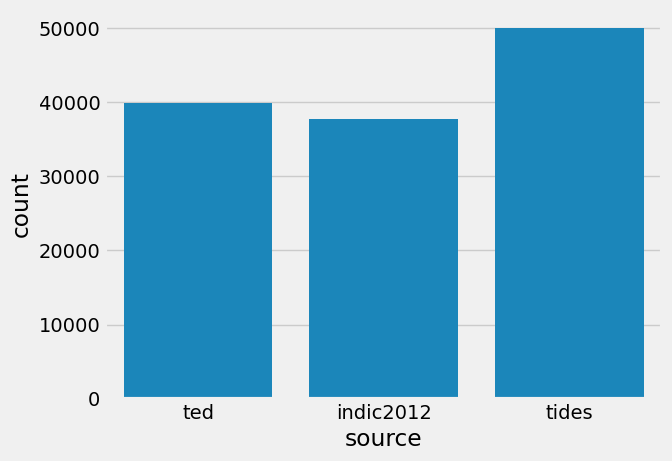

In [64]:
sns.countplot(x = data['source'],data = data)
plt.show()


In [65]:
# checking duplicated data
isDuplicated = data.duplicated().any()
if isDuplicated:
    total_duplicates = data.duplicated().sum()
    print("Total duplicate rows are: ",total_duplicates)
    data.drop_duplicates(inplace = True)

Total duplicate rows are:  2778


In [66]:
data = data.sample(n = 20000, random_state = 31)
data.shape


(20000, 3)

In [67]:
## changing uppercase to lowercase
data['english_sentence'] = data['english_sentence'].apply(lambda x: x.lower())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.lower())

In [68]:
# Remove quotes
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub("'", '', x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [69]:
to_exclude = set(string.punctuation) # Set of all special characters
print("punctuations to exclude:: ",to_exclude)
# Remove all the special characters
data['english_sentence']=data['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))

punctuations to exclude::  {'!', '(', '"', '@', '`', '_', '&', "'", '{', '[', ',', '%', '~', '-', ')', '^', '$', '>', '#', ':', '+', '.', '*', ';', '<', '\\', '=', '?', '|', '}', ']', '/'}


In [70]:
from string import digits
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)

data['english_sentence']=data['english_sentence'].apply(lambda x: x.translate(remove_digits))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
data['english_sentence']=data['english_sentence'].apply(lambda x: x.strip())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.strip())
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [71]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

In [72]:
def create_dataset(path=PATH):
    lines=pd.read_csv(path,encoding='utf-8')
    lines=lines.dropna()
    lines = lines[lines['source']=='ted']
    en = []
    hd = []
    for i, j in zip(lines['english_sentence'], lines['hindi_sentence']):
        en_1 = [preprocess_sentence(w) for w in i.split(' ')]
        en_1.append('<end>')
        en_1.insert(0, '<start>')
        hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
        hd_1.append('<end>')
        hd_1.insert(0, '<start>')
        en.append(en_1)
        hd.append(hd_1)
    return hd, en

In [73]:
def max_length(tensor):
    return max(len(t) for t in tensor)


In [74]:
tot_eng_sen = ""
for eng_sent in data["english_sentence"].tolist():
    tot_eng_sen += eng_sent + " "
    
Counter(tot_eng_sen.split(" ")).most_common(10)

[('the', 20967),
 ('of', 11934),
 ('and', 9388),
 ('to', 7679),
 ('in', 7634),
 ('a', 5844),
 ('is', 4776),
 ('that', 2973),
 ('for', 2570),
 ('was', 2566)]

In [75]:
tot_hindi_sen = ""
for hin_sent in data["hindi_sentence"].tolist():
    tot_hindi_sen += hin_sent + " "
    
Counter(tot_hindi_sen.split(" ")).most_common(10)

[('के', 14009),
 ('में', 10320),
 ('है', 9128),
 ('की', 7990),
 ('और', 7466),
 ('से', 6024),
 ('का', 5324),
 ('को', 5078),
 ('हैं', 3915),
 ('एक', 3255)]

In [76]:
cf.set_config_file(offline=True)
data["eng_char_count"] = data["english_sentence"].str.len()
data["hindi_char_count"] = data["hindi_sentence"].str.len()
data["hindi_tok_count"] = data["hindi_sentence"].str.split(" ").str.len()
data["eng_tok_count"] = data["english_sentence"].str.split(" ").str.len()

In [77]:

print(total_duplicates)

2778


DataFrame Head:


,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
114258,68,61,14,12
157,96,108,25,15
118862,184,198,36,36


DataFrame Tail:


,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
50214,74,74,16,14
98031,136,160,28,26
6633,27,25,5,4


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(20000, 4)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 114258 to 6633
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   eng_char_count    20000 non-null  int64
 1   hindi_char_count  20000 non-null  int64
 2   hindi_tok_count   20000 non-null  int64
 3   eng_tok_count     20000 non-null  int64
dtypes: int64(4)
memory usage: 781.2 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/fasteda/__init__.py:86: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/fasteda/__init__.py:86: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'eng_char_count      20000
hindi_char_count    20000
hindi_tok_count     20000
eng_tok_count       20000
Name: count, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/fasteda/__init__.py:86: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'eng_char_count      87.284
hindi_char_count    86.476
hindi_tok_count     17.162
eng_tok_count       15.334
Name: mean, dtype: object' has dtype incompatible with fl

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
eng_char_count,20000,87.284,64,81.771,0,38,64,115,2132,5.388768,74.332999
hindi_char_count,20000,86.476,64,83.16,0,37,64,112,2025,5.224880,64.119769
hindi_tok_count,20000,17.162,13,16.065,1,8,13,22,417,5.544912,75.712576
eng_tok_count,20000,15.334,12,14.093,1,7,12,20,398,5.844470,91.221852


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



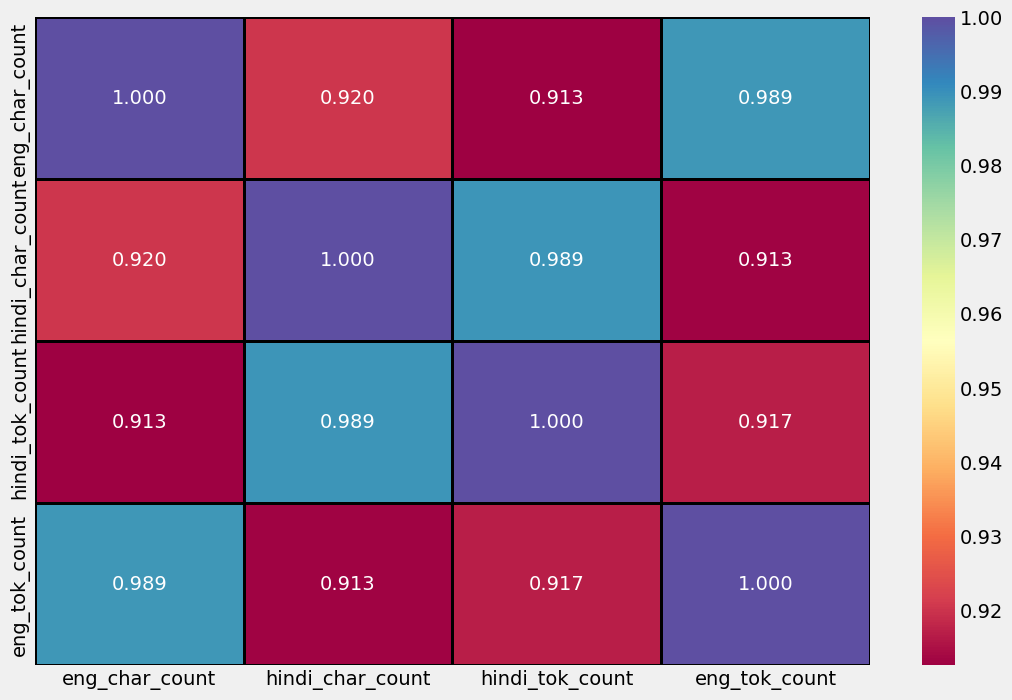

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



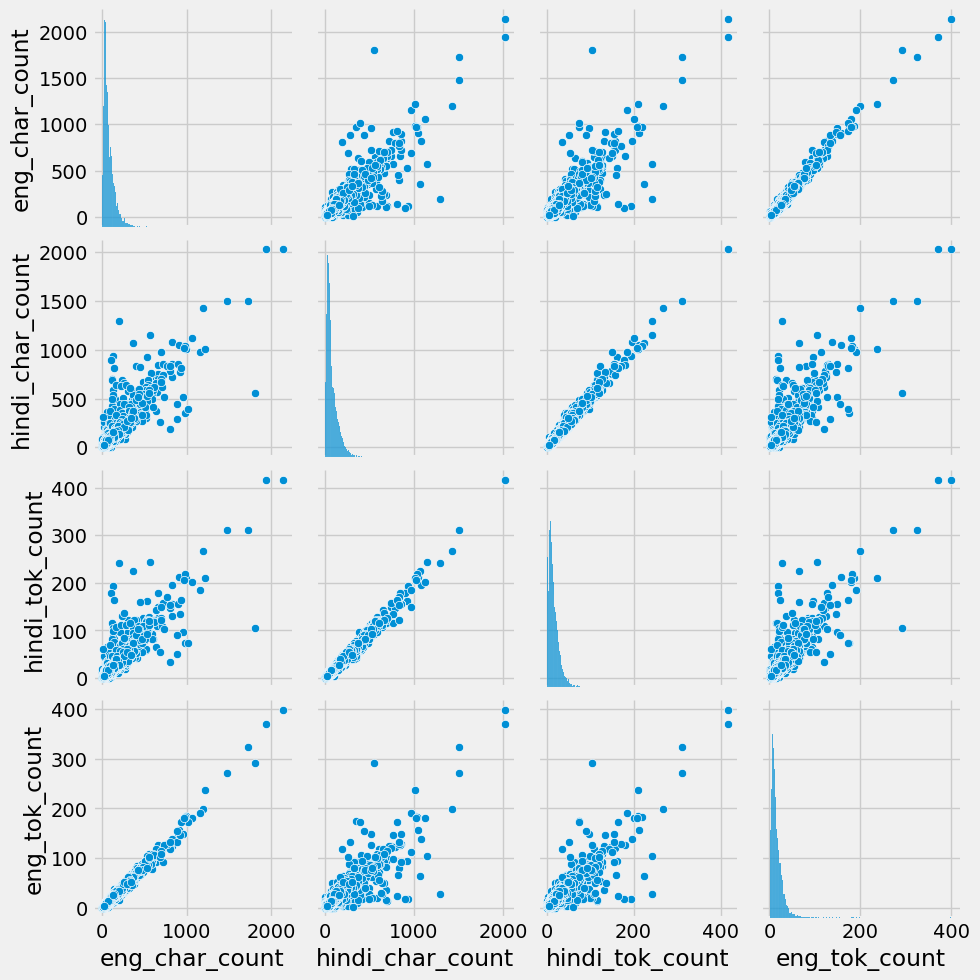

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



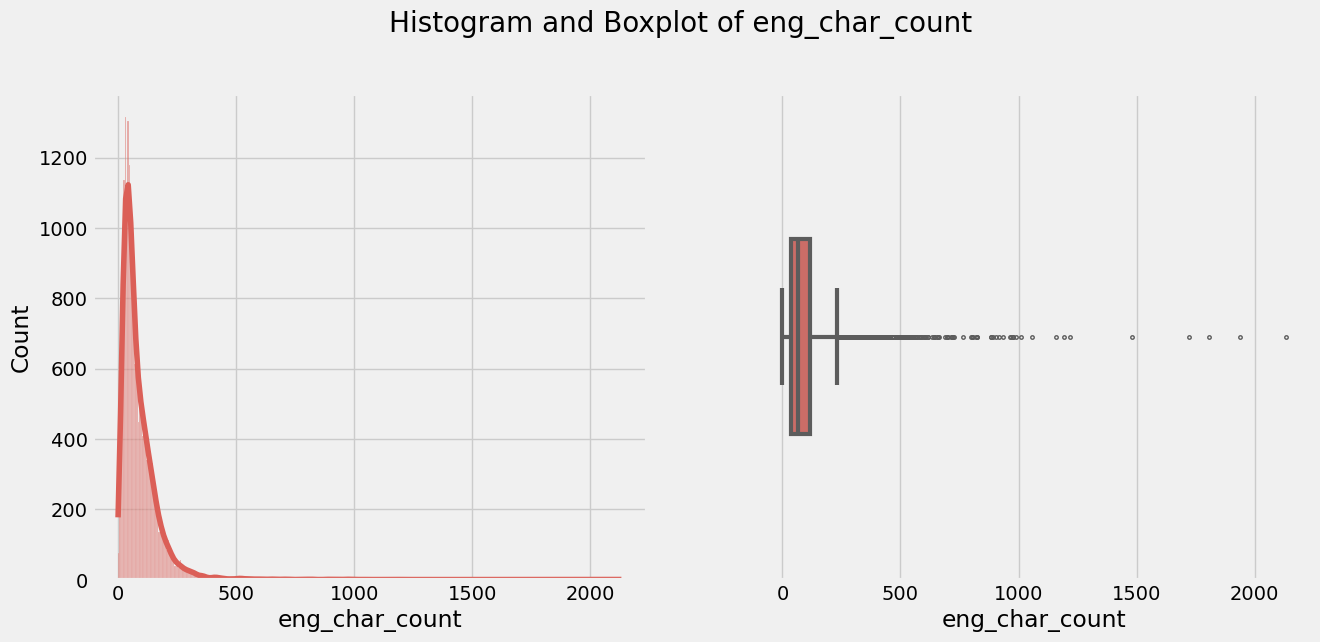

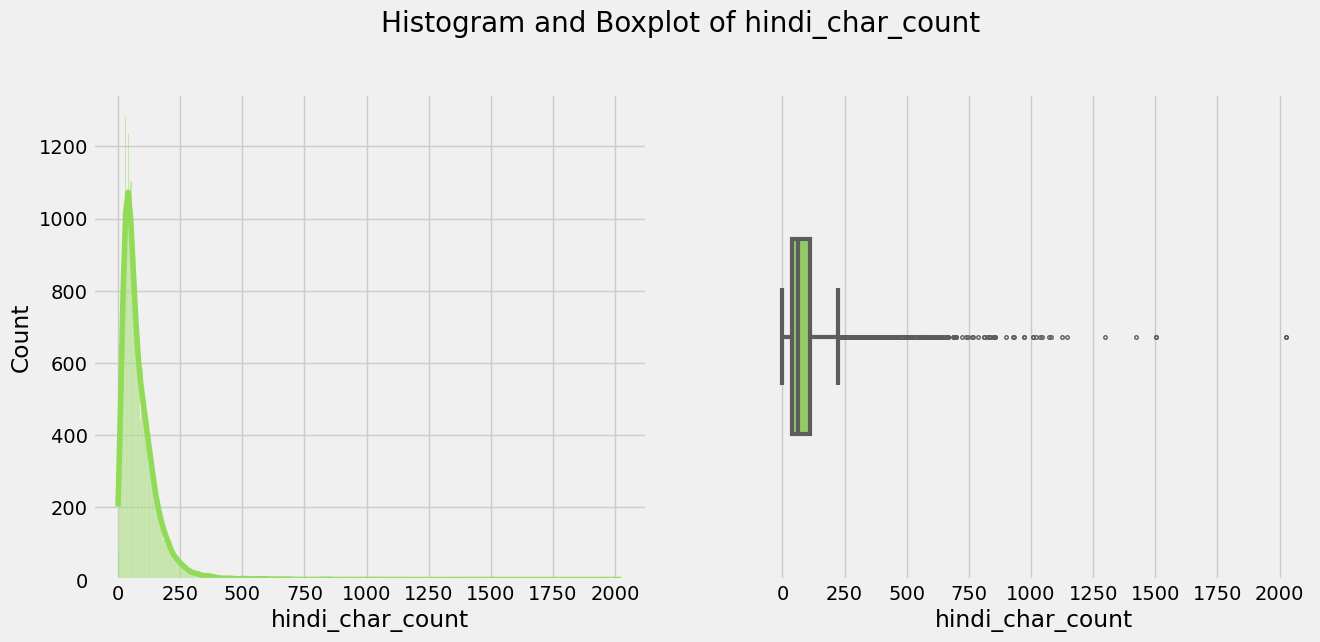

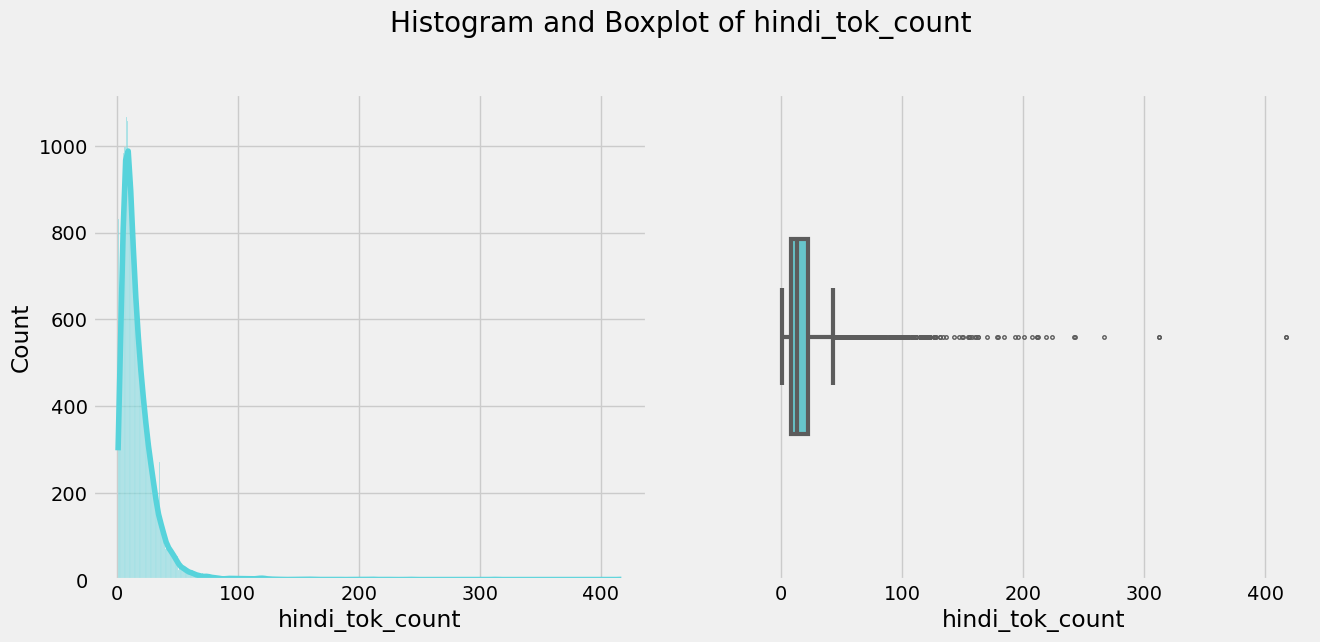

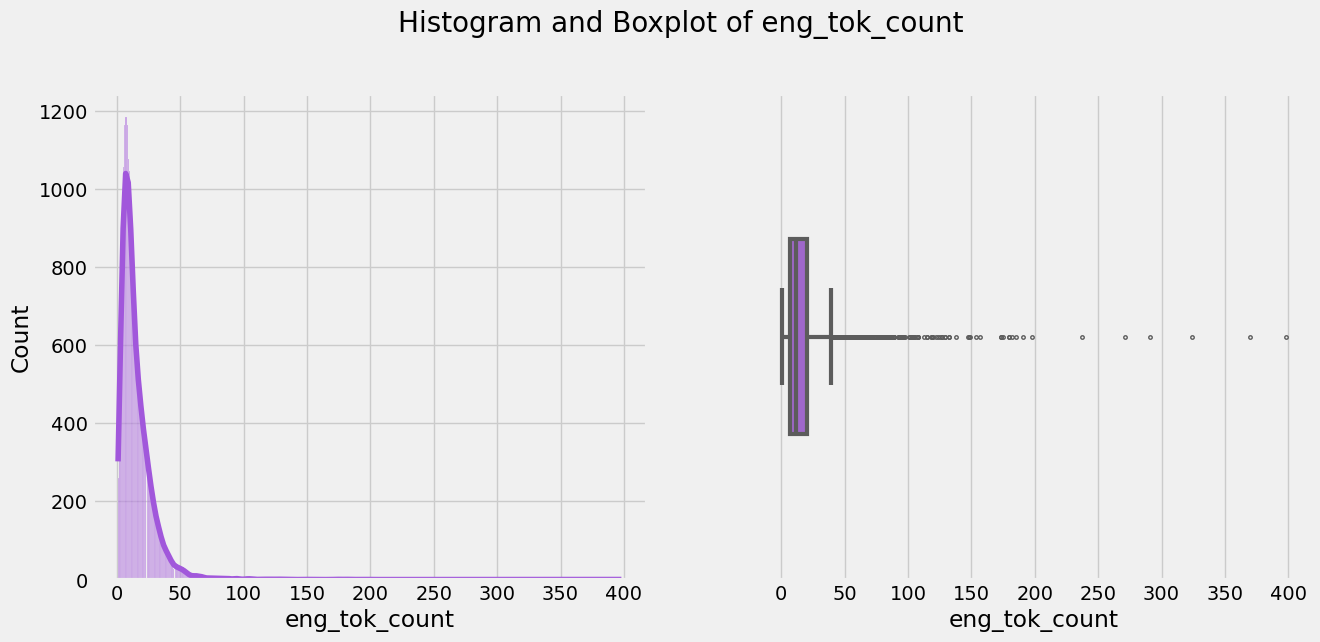

In [78]:
# Exclude non-numeric columns for fast_eda
fast_eda(data[["eng_char_count", "hindi_char_count", "hindi_tok_count", "eng_tok_count"]])

In [79]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

def load_dataset(path=PATH):
    targ_lang, inp_lang = create_dataset(path)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [80]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [81]:

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

31904 31904 7977 7977


In [82]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
75 ----> has
5 ----> to
30 ----> be
211 ----> able
5 ----> to
68 ----> see
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
560 ----> सक्षम
178 ----> होना
244 ----> चाहिए
2 ----> <end>


In [83]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [84]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self,batch_size):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [85]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [86]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [87]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    real = tf.reshape(real, [-1])  # Ensures it's flat
    loss_ = loss_object(real, pred)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [88]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [89]:

@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * inp.shape[0], 1)

        for t in tf.range(1, tf.shape(targ)[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / tf.cast(tf.shape(targ)[1], tf.float32)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss



In [90]:

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        enc_hidden = encoder.initialize_hidden_state(inp.shape[0])  # <- dynamic shape here
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')


OperatorNotAllowedInGraphError: in user code:

    File "/tmp/ipykernel_4300/1296975824.py", line 6, in train_step  *
        enc_output, enc_hidden = encoder(inp, enc_hidden)
    File "/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/ipykernel_4300/673329101.py", line 14, in call
        output, state = self.gru(x, initial_state = hidden)

    OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().
    
    [1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m
    
    Arguments received by GRU.call():
      • sequences=tf.Tensor(shape=(64, 23, 128), dtype=float32)
      • initial_state=tf.Tensor(shape=(64, 256), dtype=float32)
      • mask=None
      • training=False
